In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import sys 
import regtricks as rt 
import matplotlib.pyplot as plt
from fabber_funcs import run_basil 
from pvec_functions import calc_sphere_pvs

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf
from svb.main import run 
from svb_models_asl import AslRestModel 
from svb.data import VolumetricModel
from svb_models_asl import AslRestModel 

Instructions for updating:
non-resource variables are not supported in the long term


## SVB optimisation parameters 
It seems slow and long is the best way to go on the following simulations. LR that are too high can lead to excessively large steps being taken around either side of the true solution. LR around 0.1 and 0.05 with 4000 epochs, 5 samples seems to be a safe compromise. 

## Constants across all tests 

In [2]:
CBF = [60, 20]
ATT = [1.3, 1.6]
TAU = 1.0
REPEATS = 5 

## Single PLD data, no PVE

GM component only, across a 5x5x5 block of homogenous voxels. 5 repeats, no noise. Infer CBF only with M prior. 

In [3]:
plds = [0.8]
spc = rt.ImageSpace.create_axis_aligned([0,0,0], [5,5,5], [1,1,1])

data = np.zeros((*spc.size, REPEATS))
asl_model = AslRestModel(
        VolumetricModel(spc.make_nifti(data)), 
        plds=plds, casl=True, repeats=REPEATS, tau=TAU, att=ATT[0])

tpts = asl_model.tpts()
with tf.Session() as sess:
    ones = np.ones([spc.size.prod(), 1], dtype=np.float32)
    data = sess.run(asl_model.evaluate([CBF[0] * ones], tpts))

data = data.reshape(*spc.size, tpts.shape[-1])

The speed at which this solution converges is astonishingly slow - slower than all other cases, even though this is the simplest setup! Note by speed I don't mean runtime, I mean convergence between epochs. It takes >3k epochs to get there, whereas others take ~2k. 

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post31
INFO :  - Bolus duration: 1.0
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [1.8]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.8]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (125,), mean 1.3000000715255737
INFO :  - Bolus arrival time: array of shape (125,), mean 1.3000000715255737
INFO :  - Bolus arrival time prior std.dev.: 0.1
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (125,), mean 0.009999998845160007
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (125,), mean 0.8999999165534973
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1 value

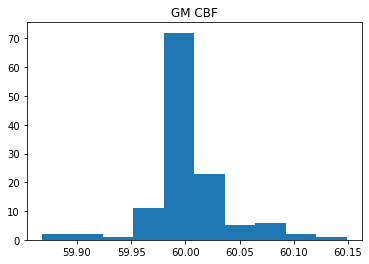

In [4]:
options = {
    "learning_rate" : 0.05,
    "batch_size" : 5,
    "sample_size" : 5,
    "epochs" : 4000,
    "log_stream" : sys.stdout,
    "display_step": 1000,  
    
    "plds": plds, 
    "repeats": REPEATS, 
    "casl": True, 
    "tau": TAU,
    "prior_type" : "M",
    "att": ATT[0],
}

runtime, svb, training_history = run(
    spc.make_nifti(data), "aslrest",
    "vol_demo", 
    **options)

means = svb.evaluate(svb.model_means)
sasl = means[0]
plt.hist(sasl); plt.title("GM CBF")
plt.show()

basil -i tempdir/data.nii.gz -o tempdir/basil_out -m tempdir/mask.nii.gz --spatial --optfile=tempdir/basil_opts.txt 
basil options: --pld=0.8 --repeats=5 --casl --fixbolus --fixbat --bat=1.3 --tau=1.0   




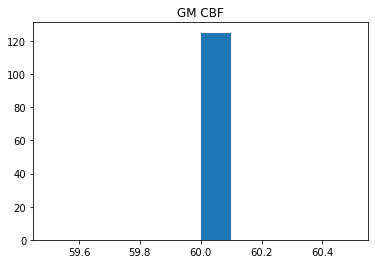

In [5]:
bopts = {
    "pld": plds[0], 
    "repeats": REPEATS, 
    "casl": True, 
    "fixbolus": True, 
    "fixbat": True,
    "bat": ATT[0],
    "tau": TAU,
}

basl, _ = run_basil(data, np.ones(spc.size), bopts)
plt.hist(basl.flatten()); plt.title("GM CBF")
plt.show()

The BASIL spatial prior seems to do a better job at enforcing similarity between voxels...

# Multi-PLD data, no PVE

Still GM only, 5 PLDs, 5 repeats, no noise. Infer CBF and ATT, with M prior on CBF. 

In [6]:
plds = [0.5, 0.7, 1.9, 1.1, 1.3]

data = np.zeros((*spc.size, len(plds) * REPEATS))
asl_model = AslRestModel(
        VolumetricModel(spc.make_nifti(data)), 
        plds=plds, casl=True, repeats=REPEATS, tau=TAU)

tpts = asl_model.tpts()
with tf.Session() as sess:
    ones = np.ones([spc.size.prod(), 1], dtype=np.float32)
    data = sess.run(asl_model.evaluate([CBF[0] * ones, ATT[0] * ones], tpts))

data = data.reshape(*spc.size, tpts.shape[-1])

Note that LR 0.1 seems to be too high here - SVB gets stuck on a solution that is ~5% out on average. 
Note also that it gets to the solution much quicker than the run above with single PLD. This is despite the optimisation having the same LR and sample size. 

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post31
INFO :  - Bolus duration: 1.0
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [1.5, 1.7, 2.9, 2.1, 2.3]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.5, 0.7, 1.9, 1.1, 1.3]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (125,), mean 1.3000000715255737
INFO :  - Bolus arrival time: 1.3
INFO :  - Bolus arrival time prior std.dev.: 1.0
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (125,), mean 0.009999998845160007
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (125,), mean 0.8999999165534973
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1 value: 1

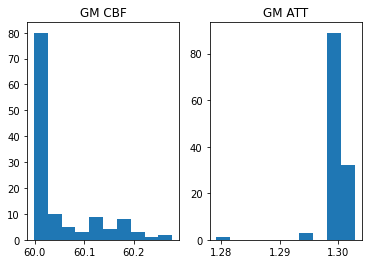

In [7]:
options = {
    "learning_rate" : 0.05,
    "batch_size" : 5,
    "sample_size" : 5,
    "epochs" : 4000,
    "log_stream" : sys.stdout,
    "display_step": 1000,  
    
    "plds": plds, 
    "repeats": REPEATS, 
    "casl": True, 
    "tau": TAU,
    "param_overrides" : {
        "ftiss" : {
            "prior_type" : "M",
        },
    }
}

runtime, svb, training_history = run(
    spc.make_nifti(data), "aslrest",
    "vol_demo", 
    **options)

means = svb.evaluate(svb.model_means)
sasl = means[0]
satt = means[1]
plt.subplot(1,2,1); plt.title("GM CBF")
plt.hist(sasl)
plt.subplot(1,2,2); plt.title("GM ATT")
plt.hist(satt)
plt.show()

basil -i tempdir/data.nii.gz -o tempdir/basil_out -m tempdir/mask.nii.gz --spatial --optfile=tempdir/basil_opts.txt 
basil options: --repeats=5 --casl --fixbolus --tau=1.0 --bat=1.0 --pld1=0.5 --pld2=0.7 --pld3=1.9 --pld4=1.1 --pld5=1.3   




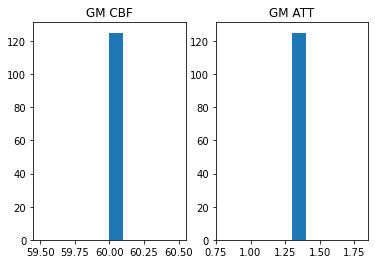

In [8]:
bopts = {
    "repeats": REPEATS, 
    "casl": True, 
    "fixbolus": True, 
    "tau": TAU,
    "bat": 1.0
}
for pidx,p in enumerate(plds): 
    bopts[f'pld{pidx+1}'] = p 

basl, batt = run_basil(data, np.ones(spc.size), bopts)
plt.subplot(1,2,1)
plt.hist(basl.flatten()); plt.title("GM CBF")
plt.subplot(1,2,2)
plt.hist(batt.flatten()); plt.title("GM ATT")
plt.show()

## Single PLD, with PVE  

GM and WM, using a spherical brain phantom. We need to ensure there are a decent number of pure voxels to ensure SVB is able to converge to the right solution. 

'Aliasing' behaviour - multiple possible solutions - is seen if the line below is uncommented. There are fewer pure GM voxels, and so the optimisation tends towards solutions where WM CBF is higher and GM CBF lower. BASIL does not seem to be affected by this to the same extent. 

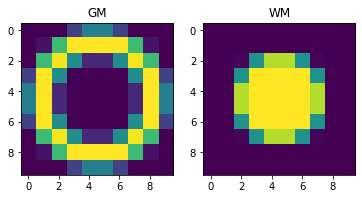

In [9]:
spc = rt.ImageSpace.create_axis_aligned([0,0,0], [10,10,10], [1,1,1])
sph_cent = spc.fov_size / 2

# This leads to a better inference, lots of pure voxels 
r1, r2 = sph_cent[0] * 0.9, sph_cent[0] * 0.6     
pvs = calc_sphere_pvs(sph_cent, r1, r2, spc, 10)
mask = (pvs > 0).any(-1)

# # Uncomment this for alias solutions, there are fewer pure voxels 
# gm = np.random.uniform(0.1, 0.9, spc.size)
# pvs = np.stack((gm, 1-gm), axis=-1)
# mask = np.ones(spc.size, dtype=np.bool)
# del gm 

plt.subplot(1,2,1)
plt.imshow(pvs[...,5,0]); plt.title("GM") 
plt.subplot(1,2,2)
plt.imshow(pvs[...,5,1]); plt.title("WM")
plt.show()

In [10]:
plds = [0.8]

data = np.zeros((*spc.size, REPEATS))
asl_model = AslRestModel(
        VolumetricModel(spc.make_nifti(data)), 
        plds=plds, casl=True, repeats=REPEATS, tau=TAU, att=ATT[0], attwm=ATT[1],
        pvgm=pvs[...,0], pvwm=pvs[...,1], pvcorr=True)

tpts = asl_model.tpts()
with tf.Session() as sess:
    ones = np.ones([spc.size.prod(), 1], dtype=np.float32)
    data = sess.run(asl_model.evaluate([CBF[0] * ones, CBF[1] * ones], tpts))

data = data.reshape(*spc.size, tpts.shape[-1])

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post31
INFO :  - Bolus duration: 1.0
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [1.8]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.8]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (576,), mean 1.3000000715255737
INFO :  - Bolus arrival time: array of shape (576,), mean 1.3000000715255737
INFO :  - Bolus arrival time prior std.dev.: 0.1
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (576,), mean 0.009999998845160007
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (576,), mean 0.9799999594688416
INFO :  - Include WM parameters: True
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: array of shape (576,), mea

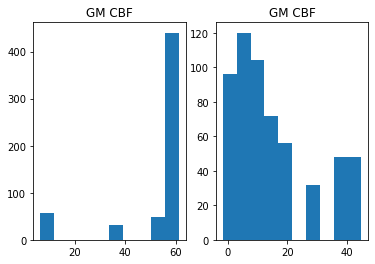

In [11]:
options = {
    "learning_rate" : 0.05,
    "batch_size" : 5,
    "sample_size" : 5,
    "epochs" : 4000,
    "log_stream" : sys.stdout,
    "display_step": 1000,  
    
    "plds": plds, 
    "repeats": REPEATS, 
    "casl": True, 
    "tau": TAU,
    "pvcorr": True, 
    "pvgm": pvs[...,0], 
    "pvwm": pvs[...,1], 
    "param_overrides" : {
        "ftiss" : { "prior_type" : "M", },
        "fwm" : { "prior_type": "M",  }
    },

}

runtime, svb, training_history = run(
    spc.make_nifti(data), "aslrest",
    "vol_demo", mask=mask,
    **options)

means = svb.evaluate(svb.model_means)
plt.subplot(1,2,1)
plt.hist(means[0]); plt.title("GM CBF")
plt.subplot(1,2,2)
plt.hist(means[1]); plt.title("GM CBF")
plt.show()

Bear in mind the above histograms, particularly for WM, contain mutliple zero voxels that do not actually have any tissue of interest. Because they are contained within the brain mask, they are included in the inference, but they cannot reliably be optimised over because they carry zero PV weight in one tissue. 

basil -i tempdir/data.nii.gz -o tempdir/basil_out -m tempdir/mask.nii.gz --spatial --optfile=tempdir/basil_opts.txt  --pgm=tempdir/pvgm.nii.gz --pwm=tempdir/pvwm.nii.gz
basil options: --pld=0.8 --repeats=5 --casl --fixbolus --fixbat --bat=1.3 --batwm=1.6 --tau=1.0   




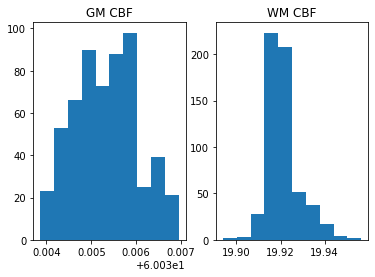

In [12]:
bopts = {
    "pld": plds[0], 
    "repeats": REPEATS, 
    "casl": True, 
    "fixbolus": True, 
    "fixbat": True,
    "bat": ATT[0],
    "batwm": ATT[1],
    "tau": TAU,
}

basl, _ = run_basil(data, mask, bopts, pvs)
plt.subplot(1,2,1)
plt.hist(basl[mask,0].flatten()); plt.title("GM CBF")
plt.subplot(1,2,2)
plt.hist(basl[mask,1].flatten()); plt.title("WM CBF")
plt.show()

Note these results look extra flattering because of all the smoothing FABBER applies within the tissue maps. Voxels that are zero-PV get their neighbours values smoothed in, leading to a perfect solution (though physiologically unrealistic). 

## Multi-PLD with PVE 

In [13]:
plds = [0.5, 0.7, 1.9, 1.1, 1.3]

data = np.zeros((*spc.size, len(plds) * REPEATS))
asl_model = AslRestModel(
        VolumetricModel(spc.make_nifti(data)), 
        plds=plds, casl=True, repeats=REPEATS, tau=TAU, att=ATT[0], attwm=ATT[1],
        pvgm=pvs[...,0], pvwm=pvs[...,1], pvcorr=True)

tpts = asl_model.tpts()
with tf.Session() as sess:
    ones = np.ones([spc.size.prod(), 1], dtype=np.float32)
    data = sess.run(asl_model.evaluate([CBF[0] * ones, ATT[0] * ones, 
                                        CBF[1] * ones, ATT[1] * ones], tpts))

data = data.reshape(*spc.size, tpts.shape[-1])

INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post31
INFO :  - Bolus duration: 1.0
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [1.5, 1.7, 2.9, 2.1, 2.3]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.5, 0.7, 1.9, 1.1, 1.3]
INFO :  - Number of repeats - single value or one per TI/PLD: 5
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (576,), mean 1.3000000715255737
INFO :  - Bolus arrival time: 1.3
INFO :  - Bolus arrival time prior std.dev.: 1.0
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (576,), mean 0.009999998845160007
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (576,), mean 0.9799999594688416
INFO :  - Include WM parameters: True
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1 value: ar

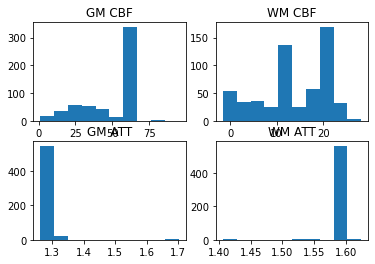

In [14]:
options = {
    "learning_rate" : 0.05,
    "batch_size" : 5,
    "sample_size" : 5,
    "epochs" : 4000,
    "log_stream" : sys.stdout,
    "display_step": 1000,  
    
    "plds": plds, 
    "repeats": REPEATS, 
    "casl": True, 
    "tau": TAU,
    "pvcorr": True, 
    "pvgm": pvs[...,0], 
    "pvwm": pvs[...,1], 
    "param_overrides" : {
        "ftiss" : { "prior_type" : "M", },
        "fwm" : { "prior_type": "M", }
    },
    
    "save_mean": True, 
    "save_cost": True, 
    "save_model_fit": True, 
    "save_post": True, 
    "save_input_data": True, 
    "save_noise": True,
}

runtime, svb, training_history = run(
    spc.make_nifti(data), "aslrest",
    "vol_demo", mask=mask,
    **options)

means = svb.evaluate(svb.model_means)
plt.subplot(2,2,1)
plt.hist(means[0]); plt.title("GM CBF")
plt.subplot(2,2,2)
plt.hist(means[2]); plt.title("WM CBF")
plt.subplot(2,2,3)
plt.hist(means[1]); plt.title("GM ATT")
plt.subplot(2,2,4)
plt.hist(means[3]); plt.title("WM ATT")
plt.show()

basil -i tempdir/data.nii.gz -o tempdir/basil_out -m tempdir/mask.nii.gz --spatial --optfile=tempdir/basil_opts.txt  --pgm=tempdir/pvgm.nii.gz --pwm=tempdir/pvwm.nii.gz
basil options: --repeats=5 --casl --fixbolus --tau=1.0 --bat=1.1 --batwm=1.9000000000000001 --pld1=0.5 --pld2=0.7 --pld3=1.9 --pld4=1.1 --pld5=1.3   




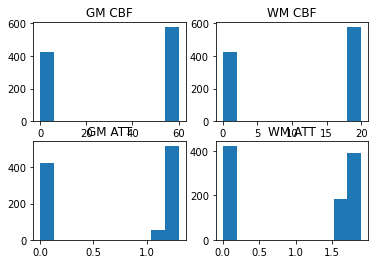

In [15]:
bopts = {
    "repeats": REPEATS, 
    "casl": True, 
    "fixbolus": True, 
    "tau": TAU,
    "bat": ATT[0] - 0.2,     # the default BAT is significantly different, so give it a sensible start 
    "batwm": ATT[1] + 0.3,
}

for pidx,pld in enumerate(plds):
    bopts[f'pld{pidx+1}'] = pld 

basl, batt = run_basil(data, mask, bopts, pvs)
plt.subplot(2,2,1)
plt.hist(basl[...,0].flatten()); plt.title("GM CBF")
plt.subplot(2,2,2)
plt.hist(basl[...,1].flatten()); plt.title("WM CBF")
plt.subplot(2,2,3)
plt.hist(batt[...,0].flatten()); plt.title("GM ATT")
plt.subplot(2,2,4)
plt.hist(batt[...,1].flatten()); plt.title("WM ATT")
plt.show()